In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
plt.rcParams.update({'font.size': 8})

# 狗狼狐狸傻傻分不清楚

![Alt text](../images/animals.png)

In [2]:
import glob
import os
import cv2
os.environ['TRIDENT_BACKEND'] = 'pytorch'
#!pip install tridentx --upgrade
import trident as T
from trident import *
from trident.models import resnet

trident 0.5.6
Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Using pillow image backend.
Pillow version:7.1.2.
Pytorch version:1.5.1+cu101.


In [3]:
#調用預訓練模型
#調用的模型會放置在 ~\.trident\models
resnet50=resnet.ResNet50(include_top=True,
             pretrained=True,
             input_shape=(3, 224, 224),
             classes=1000)

..\aten\src\ATen\native\BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


model file is already existing, donnot need download again.


<p>傳回的ResNet50的型別是名為<em>ImageClassificationModel</em>的Model子類，ImageClassificationModel需要滿足<em>class_names(標籤清單)不為空</em>以及<em>preprocess_flow的清單內放置推論前需要的圖像處理函數</em>，這樣就可以直接調用infer_single_image(img,topk=1)來進行推論，當然，這邊的預訓練模型都已經幫大家設定好了，大家不需要做任何處理，但還是讓大家瞭解一下內部到底做了些甚麼，以ResNet50為例，他的preprocess_flow設定如下：</p>

<pre><code>
preprocess_flow=[resize((224,224),keep_aspect=True),#不扭曲比例縮放至224,224
    normalize(0,255), #像素除以255
    normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),#透過imagenet像素均值標準差再做一次正規化
    ]
</code></pre>

<p>至於infer_single_image(img,topk=1)這個函數中，img可以傳入的是一個<em>圖檔路徑</em>，或者是<em>PIL讀取的圖檔</em>，也可以是一個<em>圖檔向量(通道在後，RGB)</em></p>

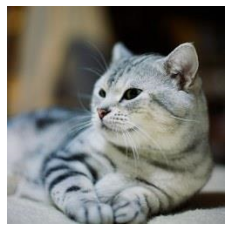

In [4]:
im=image2array('../images/cat.jpg')

plt.axis("off")
plt.imshow(im.astype(np.uint8))

In [5]:
print(resnet50.infer_single_image('../images/cat.jpg',5))

{  n02124075	埃及猫: (285, 0.92046356),  n02123159	山猫: (282, 0.03434809),  n02123045	虎斑猫: (281, 0.034243133),  n02128757	雪豹: (289, 0.0038648972),  n02129604	老虎: (292, 0.0013179512) }


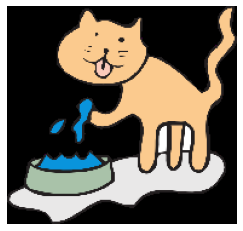

In [6]:
im=image2array('../images/manka.png')
plt.axis("off")
plt.imshow(im.astype(np.uint8))

In [7]:
print(resnet50.infer_single_image('../images/manka.png',5))

{  n03595614	運動衫: (610, 0.14498778),  n03666591	點火器: (626, 0.13289964),  n03063599	咖啡杯: (504, 0.0894865),  n03598930	拼圖: (611, 0.056703895),  n06596364	漫畫: (917, 0.05069258) }


In [8]:
data_provider=T.load_examples_data('animals')
data_provider.image_transform_funcs=[
                     random_center_crop(224,224,scale=(0.8,1.4)),
                     #原比例隨機縮放(正確縮放比例再乘上0.8~1.2之間隨機數)中央裁切至224,224
                     random_adjust_gamma(gamma=(0.8,1.2)),
                     #隨機調整圖片明暗gamma 0.6~1.4之間
                     random_adjust_contrast(scale=(0.8, 1.2)),
                     #隨機調整圖片對比度
                     normalize(0,255),#除以255
                     normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])] #透過imagenet像素均值標準差再做一次正規化
data_provider.minibatch_size=16

archive file is already existing, donnot need download again.
extraction is finished, donnot need extract again.
C:/Users/SDD2/.trident/datasets/examples_animals
['cat', 'chipmunk', 'dog', 'fox', 'giraffe', 'guinea pig', 'hyena', 'reindeer', 'sikadeer', 'squirrel', 'weasel', 'wolf']
C:/Users/SDD2/.trident/datasets/examples_animals/cat/*.*g
2766
C:/Users/SDD2/.trident/datasets/examples_animals/chipmunk/*.*g
2829
C:/Users/SDD2/.trident/datasets/examples_animals/dog/*.*g
3132
C:/Users/SDD2/.trident/datasets/examples_animals/fox/*.*g
3191
C:/Users/SDD2/.trident/datasets/examples_animals/giraffe/*.*g
3233
C:/Users/SDD2/.trident/datasets/examples_animals/guinea pig/*.*g
2970
C:/Users/SDD2/.trident/datasets/examples_animals/hyena/*.*g
2679
C:/Users/SDD2/.trident/datasets/examples_animals/reindeer/*.*g
3158
C:/Users/SDD2/.trident/datasets/examples_animals/sikadeer/*.*g
2857
C:/Users/SDD2/.trident/datasets/examples_animals/squirrel/*.*g
2551
C:/Users/SDD2/.trident/datasets/examples_animals/weas

In [9]:
finetune_resnet50=resnet.ResNet50(include_top=True,
             pretrained=True,
             input_shape=(3, 224, 224),
             classes=12)


model file is already existing, donnot need download again.


In [10]:
finetune_resnet50.summary()

--------------------------------------------------------------------------------------------------------------------------------
              Layer (type)                   Output Shape            Weight           Bias    Param #     FLOPS #   
conv2d_1                                 [-1, 64, 112, 112]    [64, 3, 7, 7]                  9408      236015360.0 
batch_norm_1                             [-1, 64, 112, 112]    [64]                 [64]      128       2395904.0   
first_block                              [-1, 64, 112, 112]                                   0         0.0         
max_pool2d_1                             [-1, 64, 56, 56]                                     0         0.0         
conv2d_3                                 [-1, 64, 56, 56]      [64, 64, 1, 1]                 4096      25686976.0  
batch_norm_3                             [-1, 64, 56, 56]      [64]                 [64]      128       598976.0    
layer1.0_0_conv                          [-1, 64, 56

In [11]:
finetune_resnet50.model.trainable=False
finetune_resnet50.summary()

23532620 parameters have set untrainable
--------------------------------------------------------------------------------------------------------------------------------
              Layer (type)                   Output Shape            Weight           Bias    Param #     FLOPS #   
conv2d_1                                 [-1, 64, 112, 112]    [64, 3, 7, 7]                  9408      236015360.0 
batch_norm_1                             [-1, 64, 112, 112]    [64]                 [64]      128       2395904.0   
first_block                              [-1, 64, 112, 112]                                   0         0.0         
max_pool2d_1                             [-1, 64, 56, 56]                                     0         0.0         
conv2d_3                                 [-1, 64, 56, 56]      [64, 64, 1, 1]                 4096      25686976.0  
batch_norm_3                             [-1, 64, 56, 56]      [64]                 [64]      128       598976.0    
layer1.0_0_

In [12]:
finetune_resnet50.model.fc.trainable=True

finetune_resnet50.summary()

24588 parameters have set trainable
--------------------------------------------------------------------------------------------------------------------------------
              Layer (type)                   Output Shape            Weight           Bias    Param #     FLOPS #   
conv2d_1                                 [-1, 64, 112, 112]    [64, 3, 7, 7]                  9408      236015360.0 
batch_norm_1                             [-1, 64, 112, 112]    [64]                 [64]      128       2395904.0   
first_block                              [-1, 64, 112, 112]                                   0         0.0         
max_pool2d_1                             [-1, 64, 56, 56]                                     0         0.0         
conv2d_3                                 [-1, 64, 56, 56]      [64, 64, 1, 1]                 4096      25686976.0  
batch_norm_3                             [-1, 64, 56, 56]      [64]                 [64]      128       598976.0    
layer1.0_0_conv 

conv2d_42                                [-1, 256, 14, 14]     [256, 256, 3, 3]               589824    231210812.0 
batch_norm_42                            [-1, 256, 14, 14]     [256]                [256]     512       150332.0    
layer3.5_1_conv                          [-1, 256, 14, 14]                                    0         0.0         
conv2d_43                                [-1, 1024, 14, 14]    [1024, 256, 1, 1]              262144    102760252.0 
batch_norm_43                            [-1, 1024, 14, 14]    [1024]               [1024]    2048      601916.0    
layer3.5_2_conv                          [-1, 1024, 14, 14]                                   0         0.0         
short_cut2d_13                           [-1, 1024, 14, 14]                                   0         0.0         
conv2d_45                                [-1, 512, 7, 7]       [512, 1024, 1, 1]              524288    51380175.0  
batch_norm_45                            [-1, 512, 7, 7]       [

In [13]:
#自訂callbacks
class CustomCallback(CallbackBase):
    def __init__(self):
        super(CustomCallback, self).__init__()
    def on_batch_end(self, training_context):
        if training_context['current_batch']==200:
            training_context['current_model'].layer4.trainable=True #透過training_context切換模型指定層的trainable狀態
        if training_context['current_batch']>0 and training_context['current_batch']%1000==0:
            training_context['optimizer'].lr=training_context['optimizer'].lr*0.5
            #每訓練1000批次，學習速率降一半
    

In [14]:
finetune_resnet50=finetune_resnet50\
    .with_optimizer(optimizer='Ranger',lr=1e-3,betas=(0.9, 0.999))\
    .with_loss(CrossEntropyLoss)\
    .with_metric(accuracy,name='accuracy')\
    .with_metric(accuracy,topk=3,name='top3_accuracy')\
    .with_regularizer('l2')\
    .with_constraint('min_max_norm')\
    .with_model_save_path('Models/finetune_resnet50.pth')
   

CrossEntropyLoss( output, target) -> CrossEntropyLoss 
CrossEntropyLoss( output, target) -> CrossEntropyLoss 
accuracy( output, target) -> accuracy 
top3_accuracy( output, target) -> top3_accuracy 


![Alt text](../images/animals_overview.jpg)

![Alt text](../images/cutmix.png)

In [15]:
finetune_resnet50=finetune_resnet50\
    .with_callbacks(CutMixCallback(alpha=1,loss_criterion=CrossEntropyLoss,loss_weight=0.5))\
    .with_callbacks(MixupCallback(alpha=1,loss_criterion=CrossEntropyLoss,loss_weight=0.2))\
    .with_callbacks(CustomCallback())

plan=TrainingPlan()\
    .add_training_item(finetune_resnet50)\
    .with_data_loader(data_provider)\
    .repeat_epochs(5)\
    .within_minibatch_size(12)\
    .print_progress_scheduling(50,unit='batch')\
    .save_model_scheduling(100,unit='batch')\
    .display_loss_metric_curve_scheduling(500,unit='batch',imshow=True)

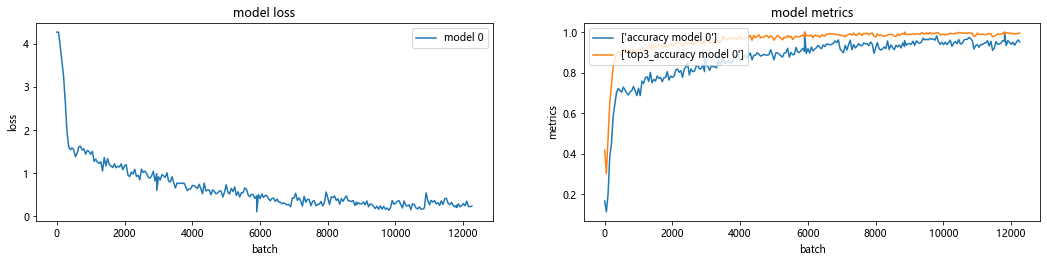

model 0      Step: 39s683ms | Loss: 0.215   | accuracy: 95.333% ,top3_accuracy: 99.167%  | learning rate: 3.906e-06 | epoch: 4  ( 500/2952 )
model 0      Step: 40s74ms  | Loss: 0.151   | accuracy: 97.333% ,top3_accuracy: 99.667%  | learning rate: 3.906e-06 | epoch: 4  ( 550/2952 )
model 0      Step: 39s199ms | Loss: 0.248   | accuracy: 95.500% ,top3_accuracy: 99.000%  | learning rate: 3.906e-06 | epoch: 4  ( 600/2952 )
model 0      Step: 40s389ms | Loss: 0.186   | accuracy: 96.333% ,top3_accuracy: 99.667%  | learning rate: 3.906e-06 | epoch: 4  ( 650/2952 )
model 0      Step: 39s561ms | Loss: 0.183   | accuracy: 97.000% ,top3_accuracy: 99.833%  | learning rate: 3.906e-06 | epoch: 4  ( 700/2952 )
model 0      Step: 42s692ms | Loss: 0.145   | accuracy: 97.500% ,top3_accuracy: 99.667%  | learning rate: 3.906e-06 | epoch: 4  ( 750/2952 )
model 0      Step: 39s486ms | Loss: 0.156   | accuracy: 97.500% ,top3_accuracy: 99.667%  | learning rate: 3.906e-06 | epoch: 4  ( 800/2952 )
model 0      

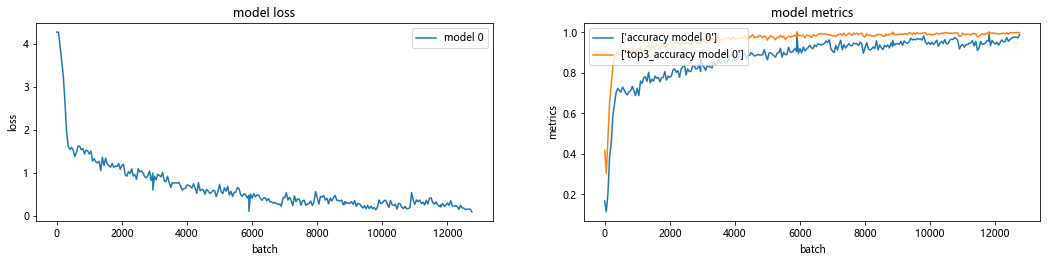

model 0      Step: 40s22ms  | Loss: 0.196   | accuracy: 96.667% ,top3_accuracy: 99.167%  | learning rate: 3.906e-06 | epoch: 4  ( 1000/2952 )
learning rate changed! ( form 3.906e-06 to 1.953e-06)
model 0      Step: 39s947ms | Loss: 0.259   | accuracy: 94.167% ,top3_accuracy: 99.833%  | learning rate: 1.953e-06 | epoch: 4  ( 1050/2952 )
model 0      Step: 39s89ms  | Loss: 0.289   | accuracy: 94.500% ,top3_accuracy: 99.000%  | learning rate: 1.953e-06 | epoch: 4  ( 1100/2952 )
model 0      Step: 40s290ms | Loss: 0.290   | accuracy: 94.500% ,top3_accuracy: 99.167%  | learning rate: 1.953e-06 | epoch: 4  ( 1150/2952 )
model 0      Step: 39s323ms | Loss: 0.299   | accuracy: 94.833% ,top3_accuracy: 99.333%  | learning rate: 1.953e-06 | epoch: 4  ( 1200/2952 )
model 0      Step: 43s282ms | Loss: 0.308   | accuracy: 93.500% ,top3_accuracy: 99.333%  | learning rate: 1.953e-06 | epoch: 4  ( 1250/2952 )
model 0      Step: 39s386ms | Loss: 0.244   | accuracy: 95.500% ,top3_accuracy: 99.000%  | lea

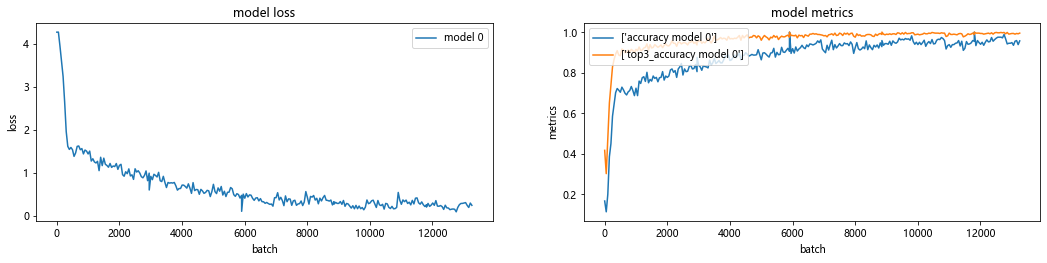

model 0      Step: 39s831ms | Loss: 0.222   | accuracy: 96.167% ,top3_accuracy: 99.167%  | learning rate: 1.953e-06 | epoch: 4  ( 1500/2952 )
model 0      Step: 41s280ms | Loss: 0.239   | accuracy: 94.333% ,top3_accuracy: 99.667%  | learning rate: 1.953e-06 | epoch: 4  ( 1550/2952 )
model 0      Step: 39s76ms  | Loss: 0.145   | accuracy: 97.167% ,top3_accuracy: 99.833%  | learning rate: 1.953e-06 | epoch: 4  ( 1600/2952 )
model 0      Step: 41s308ms | Loss: 0.283   | accuracy: 94.333% ,top3_accuracy: 99.000%  | learning rate: 1.953e-06 | epoch: 4  ( 1650/2952 )
model 0      Step: 39s522ms | Loss: 0.229   | accuracy: 96.500% ,top3_accuracy: 99.333%  | learning rate: 1.953e-06 | epoch: 4  ( 1700/2952 )
model 0      Step: 42s956ms | Loss: 0.212   | accuracy: 96.500% ,top3_accuracy: 99.667%  | learning rate: 1.953e-06 | epoch: 4  ( 1750/2952 )
model 0      Step: 39s451ms | Loss: 0.165   | accuracy: 97.333% ,top3_accuracy: 99.667%  | learning rate: 1.953e-06 | epoch: 4  ( 1800/2952 )
model 

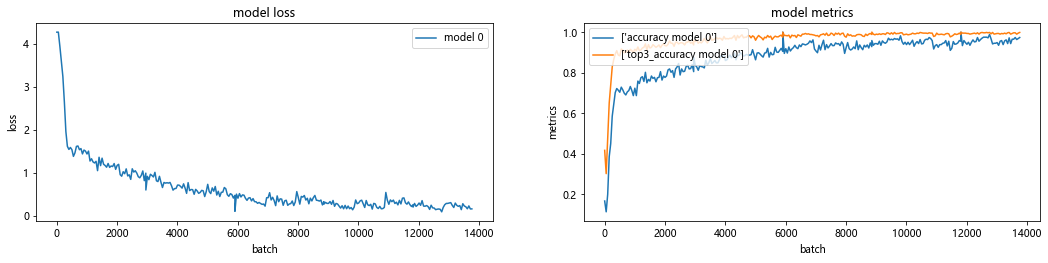

model 0      Step: 39s924ms | Loss: 0.209   | accuracy: 96.333% ,top3_accuracy: 99.500%  | learning rate: 1.953e-06 | epoch: 4  ( 2000/2952 )
learning rate changed! ( form 1.953e-06 to 9.766e-07)
model 0      Step: 42s208ms | Loss: 0.502   | accuracy: 90.833% ,top3_accuracy: 98.000%  | learning rate: 9.766e-07 | epoch: 4  ( 2050/2952 )
model 0      Step: 39s483ms | Loss: 0.282   | accuracy: 94.333% ,top3_accuracy: 98.500%  | learning rate: 9.766e-07 | epoch: 4  ( 2100/2952 )
model 0      Step: 40s159ms | Loss: 0.194   | accuracy: 95.833% ,top3_accuracy: 99.667%  | learning rate: 9.766e-07 | epoch: 4  ( 2150/2952 )
model 0      Step: 39s15ms  | Loss: 0.358   | accuracy: 93.000% ,top3_accuracy: 98.667%  | learning rate: 9.766e-07 | epoch: 4  ( 2200/2952 )
model 0      Step: 40s155ms | Loss: 0.317   | accuracy: 93.667% ,top3_accuracy: 98.500%  | learning rate: 9.766e-07 | epoch: 4  ( 2250/2952 )
model 0      Step: 39s389ms | Loss: 0.359   | accuracy: 93.667% ,top3_accuracy: 98.833%  | lea

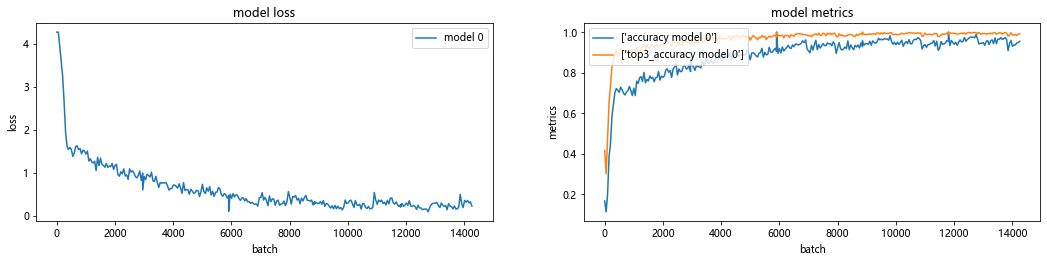

model 0      Step: 39s603ms | Loss: 0.361   | accuracy: 93.500% ,top3_accuracy: 98.667%  | learning rate: 9.766e-07 | epoch: 4  ( 2500/2952 )
model 0      Step: 42s9ms   | Loss: 0.283   | accuracy: 94.333% ,top3_accuracy: 98.500%  | learning rate: 9.766e-07 | epoch: 4  ( 2550/2952 )
model 0      Step: 39s349ms | Loss: 0.418   | accuracy: 91.333% ,top3_accuracy: 98.000%  | learning rate: 9.766e-07 | epoch: 4  ( 2600/2952 )
model 0      Step: 40s121ms | Loss: 0.382   | accuracy: 93.167% ,top3_accuracy: 98.667%  | learning rate: 9.766e-07 | epoch: 4  ( 2650/2952 )
model 0      Step: 39s390ms | Loss: 0.271   | accuracy: 94.833% ,top3_accuracy: 98.833%  | learning rate: 9.766e-07 | epoch: 4  ( 2700/2952 )
model 0      Step: 40s342ms | Loss: 0.233   | accuracy: 95.333% ,top3_accuracy: 99.500%  | learning rate: 9.766e-07 | epoch: 4  ( 2750/2952 )
model 0      Step: 39s353ms | Loss: 0.310   | accuracy: 94.833% ,top3_accuracy: 99.000%  | learning rate: 9.766e-07 | epoch: 4  ( 2800/2952 )
model 

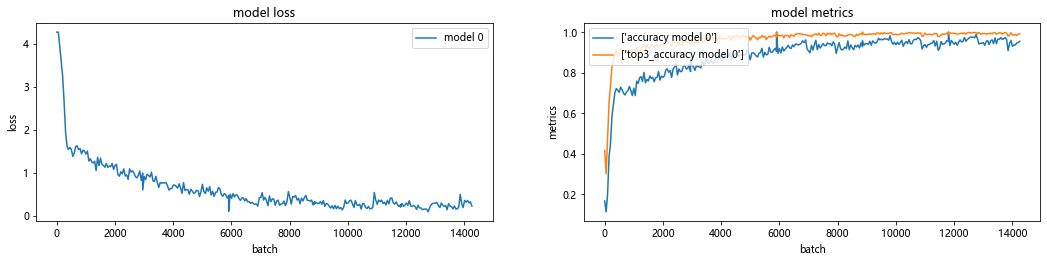

In [16]:
plan.start_now()


In [17]:
#finetune_resnet50.class_names=dataset.class_names['en-us']
finetune_resnet50.class_names=['貓 cat', '花栗鼠 chipmunk ', '狗 dog', '狐狸 fox', '長頸鹿 giraffe', '天竺鼠 guinea pig', '鬣狗 hyena', '馴鹿 reindeer', '梅花鹿 sikadeer', '松鼠 squirrel', '黃鼠狼 weasel', '狼 wolf']
print(finetune_resnet50.class_names)

['貓 cat', '花栗鼠 chipmunk ', '狗 dog', '狐狸 fox', '長頸鹿 giraffe', '天竺鼠 guinea pig', '鬣狗 hyena', '馴鹿 reindeer', '梅花鹿 sikadeer', '松鼠 squirrel', '黃鼠狼 weasel', '狼 wolf']


模型訓練好後，我們利用infer_single_image來看一下預測效果，首先是那隻手繪的貓，這次模型答對了，機率高達99.7%

{ 貓 cat: (0, 0.99716127), 狗 dog: (2, 0.0027775355), 黃鼠狼 weasel: (10, 2.0384216e-05), 松鼠 squirrel: (9, 1.8483168e-05), 狼 wolf: (11, 1.6257745e-05) }


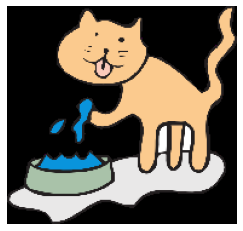

In [18]:
im=read_image('../images/manka.png')
print(finetune_resnet50.infer_single_image('../images/manka.png',5))
plt.axis("off")
plt.imshow(im.astype(np.uint8))

那扮成美國隊長的貓呢?抱歉，模型還是答錯了，以為它是一隻花栗鼠，不過各位可以發現模型對於沒把握，可能答錯這件事還是容易判斷的，你看他回答的最高機率只有83%%

{ 花栗鼠 chipmunk : (1, 0.8367343), 貓 cat: (0, 0.064679295), 松鼠 squirrel: (9, 0.03342431) }


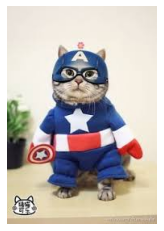

In [21]:
im=image2array('../images/captaincat.jpg')
print(finetune_resnet50.infer_single_image('../images/captaincat.jpg',topk=3))
plt.axis("off")
plt.imshow(im.astype(np.uint8))

接下來是我當時故意設計的超難題，非洲十萬年前石壁壁畫，而這次模型也答對了。

{ 長頸鹿 giraffe: (4, 0.982077), 梅花鹿 sikadeer: (8, 0.011039067), 狼 wolf: (11, 0.0064643547) }


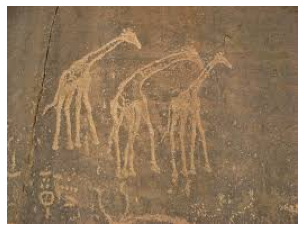

In [22]:
im=image2array('../images/africa.jpg')
print(finetune_resnet50.infer_single_image('../images/africa.jpg',topk=3))
plt.axis("off")
plt.imshow(im.astype(np.uint8))

剪紙屬於高度的抽象畫與變形，即使是如此高度抽象的圖像，模型依然是正確的。

{ 貓 cat: (0, 0.5511101), 狼 wolf: (11, 0.23123321), 天竺鼠 guinea pig: (5, 0.18332642) }


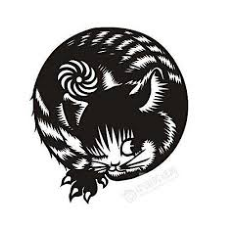

In [23]:
im=image2array('../images/paper.jpg')
print(finetune_resnet50.infer_single_image('../images/paper.jpg',topk=3))
plt.axis("off")
plt.imshow(im.astype(np.uint8))

大家熟悉的海賊王喬巴，模型也認出它是隻馴鹿。

{ 馴鹿 reindeer: (7, 0.9902952), 黃鼠狼 weasel: (10, 0.0063456567), 貓 cat: (0, 0.0012055965) }


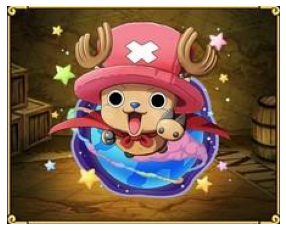

In [24]:
im=image2array('../images/joba.jpg')
print(finetune_resnet50.infer_single_image('../images/joba.jpg',topk=3))
plt.axis("off")
plt.imshow(im.astype(np.uint8))

機器會認為它是狗還是長頸鹿呢?答案是機器能判斷它是一隻扮成長頸鹿的狗。

{ 狗 dog: (2, 0.99084514), 長頸鹿 giraffe: (4, 0.0035095506), 天竺鼠 guinea pig: (5, 0.0019288003) }


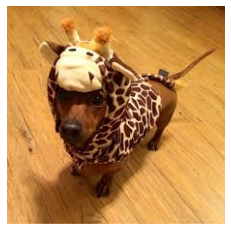

In [25]:
im=image2array('../images/fakegiraffe.jpg')
print(finetune_resnet50.infer_single_image('../images/fakegiraffe.jpg',topk=3))
plt.axis("off")
plt.imshow(im.astype(np.uint8))

這個像拖把的物體其實是稀有的長毛天竺鼠，機器也答對了。

{ 天竺鼠 guinea pig: (5, 0.9717615), 貓 cat: (0, 0.025671402), 狼 wolf: (11, 0.001199429) }


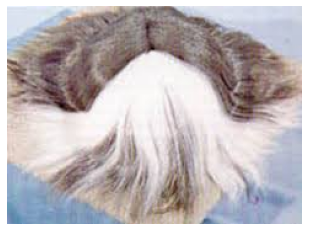

In [26]:
im=image2array('../images/longhair.jpg')#這是稀有品種長毛天竺鼠
print(finetune_resnet50.infer_single_image('../images/longhair.jpg',topk=3))
plt.axis("off")
plt.imshow(im.astype(np.uint8))